In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import get_trend_footer, load_setting
from funcs.tide import (
    conv_date_str_to_path,
    get_date_dir_from_file,
    get_date_str_from_file_2,
    get_format_date_from_date_str,
)
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

In [2]:
def plot_trend_review(code: str, df: pd.DataFrame, target_dir: str):
    n = 4

    # Matplotlib の共通設定
    FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
    fm.fontManager.addfont(FONT_PATH)

    # FontPropertiesオブジェクト生成（名前の取得のため）
    font_prop = fm.FontProperties(fname=FONT_PATH)
    font_prop.get_name()

    plt.rcParams["font.family"] = font_prop.get_name()

    if n == 1:
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.grid(axis="y")
    else:
        fig = plt.figure(figsize=(6, 6))
        ax = dict()
        gs = fig.add_gridspec(
            n,
            1,
            wspace=0.0,
            hspace=0.0,
            height_ratios=[2 if i <= 1 else 1 for i in range(n)],
        )
        for i, axis in enumerate(gs.subplots(sharex="col")):
            ax[i] = axis
            ax[i].grid(axis="y")

    name = get_ticker_name_list([code])[code]
    format_date = get_format_date_from_date_str(date_str)
    ax[0].plot(df["price"], linewidth=0.5, color="gray", alpha=0.5, label="株価")
    ax[0].plot(df["ma1"], linewidth=0.5, color="#008000", label="移動平均線 MA1")
    ax[0].plot(df["vwap"], linewidth=0.75, color="#ff00ff", label="VWAP")
    # ax[0].set_xlabel(title_str, fontsize=5)
    ax[0].set_ylabel("株価")
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax[0].legend(fontsize=6)

    ax[1].plot(
        df["price"] - df["vwap"],
        linewidth=0.5,
        color="gray",
        alpha=0.5,
        label="株価 - VWAP",
    )
    ax[1].plot(df["ma1"] - df["vwap"], linewidth=0.5, color="#f0c000", label="MA1 - VWAP")
    ax[1].axhline(y=0, linewidth=0.5, color="black")
    ax[1].set_ylabel("乖離度")
    ax[1].legend(fontsize=6)

    ax[2].plot(df["profit"], linewidth=0.5, color="#ff00ff", alpha=0.75, label="含み損益")
    ax[2].plot(df["profit_max"], linewidth=0.75, color="#ff0000", label="最大含み損益")
    ax[2].axhline(
        y=dict_setting["DD_PROFIT"],
        linewidth=0.75,
        color="C1",
        alpha=1,
        label="トレーリング",
    )
    ax[2].set_ylabel("含み損益")
    ax[2].legend(fontsize=6)

    ax[3].plot(df["dd_ratio"], linewidth=0.5, color="C0", alpha=0.75, label="DD ratio")
    ax[3].axhline(
        y=dict_setting["DD_RATIO"], linewidth=0.75, color="C1", label="利確ライン"
    )
    ax[3].set_ylabel("DD ratio")
    ax[3].legend(fontsize=6)
    ax[3].set_ylim(0, 1.1)

    list_cross = df[df["cross1"] != 0].index
    print(f"# of cross: {len(list_cross)}")
    for i in range(n):
        for t in list_cross:
            if 0 < df.at[t, "cross1"]:
                cname = "#f00000"
            else:
                cname = "#0000d0"
            ax[i].axvline(x=t, color=cname, linestyle="solid", linewidth=0.75)

    ax[0].set_title(f"{format_date}: {name} ({code})")
    ax[n - 1].set_xlabel(f"# of crossed: {len(list_cross)} times")

    # plt.suptitle(title_str, fontsize=5)
    plt.tight_layout()
    # plt.subplots_adjust(top=0.89)
    output = os.path.join(target_dir, f"{code}_trend_technical.png")
    print(output)
    plt.savefig(output)
    plt.show()

{'PERIOD_WARMUP': 300, 'PERIOD_MA_1': 30, 'LOSSCUT_1': -3.0, 'N_MINUS_MAX': 150, 'DD_PROFIT': 3.0, 'DD_RATIO': 0.9}
# of cross: 10
output/2026/02/18/4005_trend_technical.png


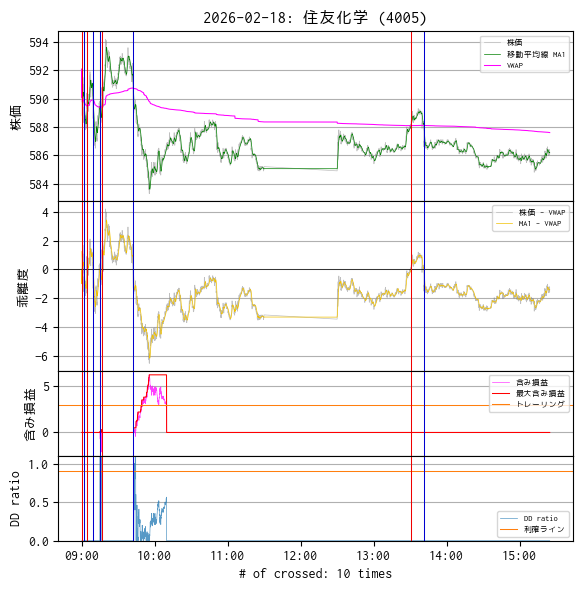

{'PERIOD_WARMUP': 300, 'PERIOD_MA_1': 30, 'LOSSCUT_1': -3.0, 'N_MINUS_MAX': 150, 'DD_PROFIT': 2.0, 'DD_RATIO': 0.9}
# of cross: 9
output/2026/02/18/4689_trend_technical.png


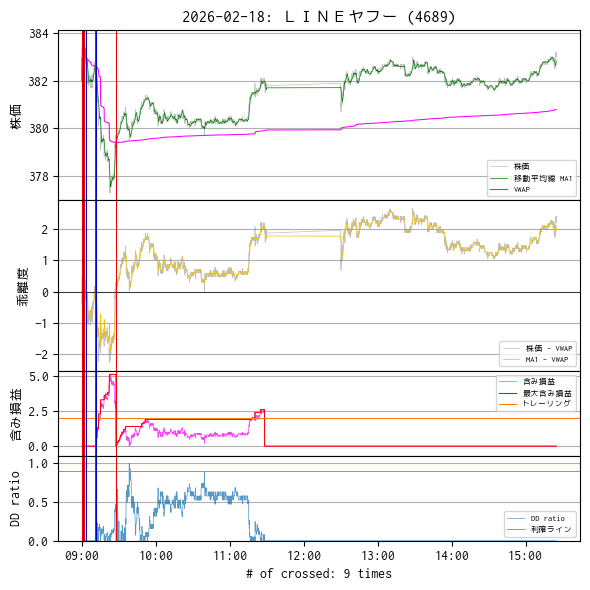

{'PERIOD_WARMUP': 300, 'PERIOD_MA_1': 30, 'LOSSCUT_1': -3.0, 'N_MINUS_MAX': 150, 'DD_PROFIT': 3.0, 'DD_RATIO': 0.9}
# of cross: 12
output/2026/02/18/8604_trend_technical.png


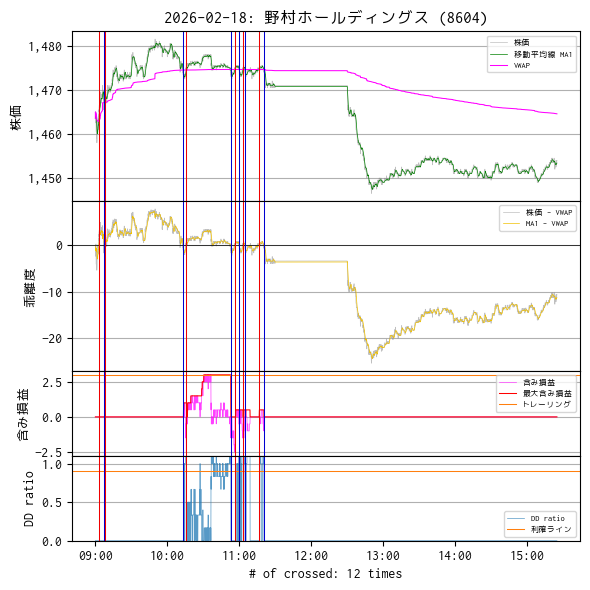

In [3]:
debug = False

res = AppRes()
date_str = "20260218"
for code in ["4005","4689","8604"]:
    dict_setting = load_setting(res, code)
    print(dict_setting)
    
    if debug:
        base_dir = res.dir_temp
    else:
        base_dir = res.dir_output
    
    target_dir = os.path.join(base_dir, conv_date_str_to_path(date_str))
    path_csv = os.path.join(target_dir, f"{code}_technicals.csv")
    df = pd.read_csv(path_csv, index_col=0)
    df.index = [pd.to_datetime(t) for t in df.index]
    
    plot_trend_review(code, df, target_dir)